# Literature Search Crawl Report

Generate various stats validations from the artifacts of the literature search

In [1]:
import os
import re
import requests
import json
import sqlite3
import pandas as pd
import pprint
import matplotlib.pyplot as plt
    
os.chdir(os.path.expanduser("/home/jovyan/data/pubmunch/crawl/"))

## Download

In [2]:
with open("download/pmids.txt") as f:
    pmids = set(f.read().splitlines())
print("{} PMIDs attempted".format(len(pmids)))

16980 PMIDs attempted


In [3]:
download = pd.read_csv("download/docStatus.tab",
                       sep="\t", header=None, index_col=False, dtype=str,
                       names=["pmid", "status", "msg", "crawler", "journal", "year", "numFiles", "detail"])

print("{} ({}%) succeeded\n {} ({}%) failed\n".format(
    download[download.status == "OK"].shape[0], 
    round(100 * download[download.status == "OK"].shape[0] / len(pmids)),
    download[download.status != "OK"].shape[0], 
    round(100 * download[download.status != "OK"].shape[0] / len(pmids))))
print(download.status.value_counts())

14088 (83%) succeeded
 2753 (16%) failed

OK                     14088
invalidPdf               978
noCrawlerSuccess         817
httpError                302
noLicense                301
HighwirePdfNotValid      254
invalidHostname           55
pageErrorMessage          28
no_meta                    9
noOutlinkOrDoi             6
BeautifulSoupError         1
tooManySupplFiles          1
HtmlParseError             1
Name: status, dtype: int64


## Find

In [4]:
variants = pd.read_csv("output/release/built_with_change_types.tsv",
                       sep="\t", header=0, encoding="utf-8",
                       usecols=["pyhgvs_Genomic_Coordinate_38", "pyhgvs_cDNA", "Synonyms"])
    
print("{} variants in BRCA Exchange".format(variants.shape[0]))

mentions = pd.read_csv("mutations-trimmed.tsv",
                       sep="\t", header=0, encoding="utf-8", dtype="str")
print("{} mentions found".format(mentions.shape[0]))

matches = pd.read_csv("mentions-matched.tsv", sep="\t", header=0, encoding="utf-8")
print("{} matches found".format(matches.shape[0]))

21695 variants in BRCA Exchange
425890 mentions found
174932 matches found


In [5]:
matches.points.describe()

count    174932.000000
mean          5.327493
std           3.333842
min           1.000000
25%           2.000000
50%           5.000000
75%           7.000000
max          50.000000
Name: points, dtype: float64

In [6]:
with open("literature.json") as f:
    lit = json.loads(f.read())
print("{} Papers and {} Variants exported".format(len(lit["papers"]), len(lit["variants"])))

3615 Papers and 9783 Variants exported


In [7]:
print("Papers that didn't yield any variants:")
print(set(pmids) - set(lit["papers"].keys()))

Papers that didn't yield any variants:
{'9893667', '10528224', '30001383', '25512557', '22976806', '7590743', '23520118', '26319584', '21896163', '16777318', '29335712', '29145865', '28825054', '18660546', '27994514', '16491617', '11313470', '30006425', '8833256', '29036688', '14594711', '30220950', '15135645', '20007017', '28693174', '27367496', '18241344', '22234518', '11877377', '28644335', '12973351', '10480351', '16528612', '27498762', '22304686', '20443055', '29932943', '25032037', '24616882', '28810691', '15796777', '28564596', '17914334', '21761160', '20195775', '19939726', '15591126', '19258448', '16337408', '16914727', '16951155', '25909142', '16824695', '18951438', '22875640', '22333603', '19739093', '30388923', '25675043', '10560359', '2841861', '11545685', '29943416', '15340083', '16108063', '15139048', '21558506', '17599047', '7581488', '27315300', '26257769', '24013569', '26873923', '17374731', '22098958', '29763720', '24492479', '10071299', '8967365', '28768733', '25216

In [8]:
# print("Max mentions for a single variant: {} {}".format(
#     exploded.groupby(["pyhgvs_Genomic_Coordinate_38"]).size().idxmax(),
#     exploded.groupby(["pyhgvs_Genomic_Coordinate_38"]).size().max()))

# print("Max mentions for a single paper from one variant: {} {}".format(
#     exploded.groupby(["pyhgvs_Genomic_Coordinate_38", "pmid"]).size().idxmax(),
#     exploded.groupby(["pyhgvs_Genomic_Coordinate_38", "pmid"]).size().max()))

# print("Paper referenced from the most variants: {} {}".format(
#     exploded.groupby(["pmid"]).size().idxmax(),
#     exploded.groupby(["pmid"]).size().max()))

## Founder Mutations

Make sure the variant matches to several founder mutation articles as reported [here](https://github.com/BRCAChallenge/pubMunch-BRCA/issues/10) are present.

In [9]:
# Make sure all the articles were in the crawl
assert set(['12473589', '15994883', '9042909', '21987798', '16397213', '20608970', '11352856', 
 '9145676', '25192939', '21598239', '28122244', '14576434', '20215531', '18158280', '22430266']).issubset(pmids)

In [10]:
text = """
Abeliovich et al. 1997 à https://www.ncbi.nlm.nih.gov/pubmed/9042909 (in article title)
Antoniou et al. 2005 à https://www.ncbi.nlm.nih.gov/pubmed/15994883 (in article title)
Chodick et al. 2008 à https://www.ncbi.nlm.nih.gov/pubmed/18158280 (in article abstract)
Elstrodt et al. 2006 à https://www.ncbi.nlm.nih.gov/pubmed/16397213 (in article abstract)
Finkelman et al. 2012 à https://www.ncbi.nlm.nih.gov/pubmed/22430266 (in article abstract)
Gabai-Kapara et al. 2014 à https://www.ncbi.nlm.nih.gov/pubmed/25192939 (in article introduction and methods)
King et al. 2003 à https://www.ncbi.nlm.nih.gov/pubmed/14576434 (in article)
Konishi et al. 2011 à https://www.ncbi.nlm.nih.gov/pubmed/21987798 (in abstract)
Linger and Kruk 2010 à https://www.ncbi.nlm.nih.gov/pubmed/20608970 (in article)
Satagopan et al. 2001 à https://www.ncbi.nlm.nih.gov/pubmed/11352856 (in abstract)
Satagopan et al. 2002 à https://www.ncbi.nlm.nih.gov/pubmed/12473589 (in abstract)
Stadler et al. 2012 à https://www.ncbi.nlm.nih.gov/pubmed/21598239 (in abstract)
Struewing et al. 1997 à https://www.ncbi.nlm.nih.gov/pubmed/9145676 (in abstract)
Abeliovich et al. 1997 à https://www.ncbi.nlm.nih.gov/pubmed/9042909 (in article title)
Antoniou et al. 2005 à https://www.ncbi.nlm.nih.gov/pubmed/15994883 (in article title)
Finkelman et al. 2012 à https://www.ncbi.nlm.nih.gov/pubmed/22430266 (in article)
Gabai-Kapara et al. 2014 à https://www.ncbi.nlm.nih.gov/pubmed/25192939 (in article introduction and methods)
King et al. 2003 à https://www.ncbi.nlm.nih.gov/pubmed/14576434 (in article)
Mgbemena et al. 2017 à https://www.ncbi.nlm.nih.gov/pubmed/28122244 (in abstract)
Satagopan et al. 2002 à https://www.ncbi.nlm.nih.gov/pubmed/12473589 (in abstract)
Struewing et al. 1997 à https://www.ncbi.nlm.nih.gov/pubmed/9145676 (in abstract)
Abeliovich et al. 1997 à https://www.ncbi.nlm.nih.gov/pubmed/9042909 (in article title)
Antoniou et al. 2005 à https://www.ncbi.nlm.nih.gov/pubmed/15994883 (in article title)
Chodick et al. 2008 à https://www.ncbi.nlm.nih.gov/pubmed/18158280 (in article abstract)
Finkelman et al. 2012 à https://www.ncbi.nlm.nih.gov/pubmed/22430266 (in article abstract)
Gabai-Kapara et al. 2014 à https://www.ncbi.nlm.nih.gov/pubmed/25192939 (in article introduction and methods)
Gallagher et al. 2010 à https://www.ncbi.nlm.nih.gov/pubmed/20215531 (in methods)
King et al. 2003 à https://www.ncbi.nlm.nih.gov/pubmed/14576434 (in article)
Satagopan et al. 2001 à https://www.ncbi.nlm.nih.gov/pubmed/11352856 (in abstract)
Satagopan et al. 2002 à https://www.ncbi.nlm.nih.gov/pubmed/12473589 (in abstract)
Struewing et al. 1997 à https://www.ncbi.nlm.nih.gov/pubmed/9145676 (in abstract)
"""
print(set(re.findall(r"\/(\d+)", text)))


{'21987798', '18158280', '12473589', '20215531', '22430266', '28122244', '25192939', '21598239', '14576434', '9145676', '16397213', '15994883', '20608970', '9042909', '11352856'}


In [11]:
# BRCA1 185delAG: https://brcaexchange.org/variant/183889
# chr17:g.43124027:ACT>A
text = """
Abeliovich et al. 1997 à https://www.ncbi.nlm.nih.gov/pubmed/9042909 (in article title)
Antoniou et al. 2005 à https://www.ncbi.nlm.nih.gov/pubmed/15994883 (in article title)
Chodick et al. 2008 à https://www.ncbi.nlm.nih.gov/pubmed/18158280 (in article abstract)
Elstrodt et al. 2006 à https://www.ncbi.nlm.nih.gov/pubmed/16397213 (in article abstract)
Finkelman et al. 2012 à https://www.ncbi.nlm.nih.gov/pubmed/22430266 (in article abstract)
Gabai-Kapara et al. 2014 à https://www.ncbi.nlm.nih.gov/pubmed/25192939 (in article introduction and methods)
King et al. 2003 à https://www.ncbi.nlm.nih.gov/pubmed/14576434 (in article)
Konishi et al. 2011 à https://www.ncbi.nlm.nih.gov/pubmed/21987798 (in abstract)
Linger and Kruk 2010 à https://www.ncbi.nlm.nih.gov/pubmed/20608970 (in article)
Satagopan et al. 2001 à https://www.ncbi.nlm.nih.gov/pubmed/11352856 (in abstract)
Satagopan et al. 2002 à https://www.ncbi.nlm.nih.gov/pubmed/12473589 (in abstract)
Stadler et al. 2012 à https://www.ncbi.nlm.nih.gov/pubmed/21598239 (in abstract)
Struewing et al. 1997 à https://www.ncbi.nlm.nih.gov/pubmed/9145676 (in abstract)

Struewing et al. 1997 à https://www.ncbi.nlm.nih.gov/pubmed/111111 Spikein :-)
"""
print(set(re.findall(r"\/(\d+)", text)).difference(
    set([v["pmid"] for v in lit["variants"]["chr17:g.43124027:ACT>A"]])))
print("Not Crawled:", set(re.findall(r"\/(\d+)", text)) - set(pmids))

{'111111'}
Not Crawled: {'111111'}


In [12]:
# **BRCA1 5382insC: https://brcaexchange.org/variant/180141**
# chr17:g.43057062:T>TG
text = """
Abeliovich et al. 1997 à https://www.ncbi.nlm.nih.gov/pubmed/9042909 (in article title)
Antoniou et al. 2005 à https://www.ncbi.nlm.nih.gov/pubmed/15994883 (in article title)
Finkelman et al. 2012 à https://www.ncbi.nlm.nih.gov/pubmed/22430266 (in article)
Gabai-Kapara et al. 2014 à https://www.ncbi.nlm.nih.gov/pubmed/25192939 (in article introduction and methods)
King et al. 2003 à https://www.ncbi.nlm.nih.gov/pubmed/14576434 (in article)
Mgbemena et al. 2017 à https://www.ncbi.nlm.nih.gov/pubmed/28122244 (in abstract)
Satagopan et al. 2002 à https://www.ncbi.nlm.nih.gov/pubmed/12473589 (in abstract)
Struewing et al. 1997 à https://www.ncbi.nlm.nih.gov/pubmed/9145676 (in abstract)

Struewing et al. 1997 à https://www.ncbi.nlm.nih.gov/pubmed/111111 Spikein :-)
"""
print(set(re.findall(r"\/(\d+)", text)).difference(
    set([v["pmid"] for v in lit["variants"]["chr17:g.43057062:T>TG"]])))
print("Not Crawled:", set(re.findall(r"\/(\d+)", text)) - set(pmids))

{'111111', '28122244'}
Not Crawled: {'111111'}


In [13]:
# **BRCA2 6174delT: https://brcaexchange.org/variant/177049**
# chr13:g.32340526:AT>A
text = """
Abeliovich et al. 1997 à https://www.ncbi.nlm.nih.gov/pubmed/9042909 (in article title)
Antoniou et al. 2005 à https://www.ncbi.nlm.nih.gov/pubmed/15994883 (in article title)
Chodick et al. 2008 à https://www.ncbi.nlm.nih.gov/pubmed/18158280 (in article abstract)
Finkelman et al. 2012 à https://www.ncbi.nlm.nih.gov/pubmed/22430266 (in article abstract)
Gabai-Kapara et al. 2014 à https://www.ncbi.nlm.nih.gov/pubmed/25192939 (in article introduction and methods)
Gallagher et al. 2010 à https://www.ncbi.nlm.nih.gov/pubmed/20215531 (in methods)
King et al. 2003 à https://www.ncbi.nlm.nih.gov/pubmed/14576434 (in article)
Satagopan et al. 2001 à https://www.ncbi.nlm.nih.gov/pubmed/11352856 (in abstract)
Satagopan et al. 2002 à https://www.ncbi.nlm.nih.gov/pubmed/12473589 (in abstract)
Struewing et al. 1997 à https://www.ncbi.nlm.nih.gov/pubmed/9145676 (in abstract)

Struewing et al. 1997 à https://www.ncbi.nlm.nih.gov/pubmed/111111 Spikein :-)
"""
print(set(re.findall(r"\/(\d+)", text)).difference(
    set([v["pmid"] for v in lit["variants"]["chr13:g.32340526:AT>A"]])))
print("Not Crawled:", set(re.findall(r"\/(\d+)", text)) - set(pmids))

{'111111'}
Not Crawled: {'111111'}


## LOVD

In [14]:
lovd = pd.read_table(
    "https://raw.githubusercontent.com/BRCAChallenge/pubMunch-BRCA/master/tests/lovd-normalized.tsv", dtype=str)
print("{} pmids and {} variants in normalized LOVD truth set".format(
    len(set(lovd.pmid.values)),
    len(set(lovd.pyhgvs_Genomic_Coordinate_38.values))))
lovd.head()

175 pmids and 1044 variants in normalized LOVD truth set


,pmid,norm_c_hgvs,norm_g_hgvs,pyhgvs_Genomic_Coordinate_38
0,24667779,NM_007294.3:c.-19-22_-19-21dup,NC_000017.11:g.43124146_43124147dup,chr17:g.43124146_43124147:dup
1,10459348,NM_007294.3:c.-19-10T>C,NC_000017.11:g.43124125A>G,chr17:g.43124125:A>G
2,24667779,NM_007294.3:c.-19-10T>C,NC_000017.11:g.43124125A>G,chr17:g.43124125:A>G
3,16403807,NM_007294.3:c.-3G>C,NC_000017.11:g.43124099C>G,chr17:g.43124099:C>G
4,19393826,NM_007294.3:c.1_134del,NC_000017.11:g.43115728_43124098del,chr17:g.43115728_43124098:del


In [15]:
print("Missing from list of PMIDs to download:")
print(", ".join([p for p in set(lovd.pmid.values) if p not in pmids]))

print("\nFailed to download:")
print(", ".join(["{} ({})".format(p, download[download.pmid == p].status.values[0]) 
                   for p in set(lovd.pmid.values) if 
                   download[(download.pmid == p) & (download.status != "OK")].shape[0]]))

Missing from list of PMIDs to download:
07545954, 08942979, 08896551, 08751436, 09497265, 09523200, 09126734, 18415037, 09805131, 09333265, 08531967, 09971877, 19150617, 12900794, 09585599, 07939630, 2010

Failed to download:
18375895 (HighwirePdfNotValid), 17657584 (invalidPdf), 12955716 (invalidPdf), 16211554 (invalidPdf), 18680205 (invalidPdf), 10506595 (HighwirePdfNotValid), 12601471 (httpError), 19287957 (noCrawlerSuccess), 16619214 (invalidPdf), 16528612 (invalidPdf), 20054658 (invalidPdf), 16969499 (noCrawlerSuccess), 17305420 (httpError), 18693280 (invalidPdf), 15533909 (HighwirePdfNotValid), 12552570 (invalidPdf), 10406662 (invalidPdf), 12815598 (invalidPdf), 12955719 (invalidPdf), 17279547 (invalidPdf), 16786532 (invalidPdf), 20513136 (invalidPdf), 18493658 (noCrawlerSuccess), 20020529 (invalidPdf), 15300854 (invalidPdf), 11385711 (invalidPdf)


In [16]:
common_pmids = list(set(lit["papers"].keys()).intersection(set(lovd.pmid.values)))
print("{} common pmids between LOVD and this crawl".format(len(common_pmids)))

125 common pmids between LOVD and this crawl


In [17]:
# Invert the literature.json exported to BRCA Exchange to create a variants by pmid from literature
import itertools

lit_pmid_variant_tuple = [(hit["pmid"], variant)
                          for variant, hits in lit["variants"].items()
                          for hit in hits]

lit_variants_by_pmid = {pmid: [v[1] 
                        for v in variants]
                        for pmid, variants in itertools.groupby(sorted(lit_pmid_variant_tuple), lambda x: x[0])}

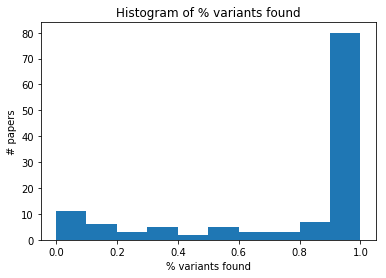

In [18]:
# Compute per paper the % of LOVD variants we found and exported in literature.json
pcts = {
    p: len(set(lit_variants_by_pmid[p]).intersection(
        set(lovd[lovd.pmid == p].pyhgvs_Genomic_Coordinate_38.values))) / len(
        set(lovd[lovd.pmid == p].pyhgvs_Genomic_Coordinate_38.values)) 
    for p in common_pmids}

lovd_stats = pd.DataFrame.from_dict(pcts, orient="index", columns=["pct"]).rename_axis("pmid")

plt.hist(lovd_stats.pct)
plt.title("Histogram of % variants found")
plt.xlabel("% variants found")
plt.ylabel("# papers")
plt.show()

## Compare Current LOVD

In [19]:
with open("/home/jovyan/public_html/literature-2018-11-14.json") as f:
    lit = json.loads(f.read())
print("{} Papers and {} Variants exported".format(len(lit["papers"]), len(lit["variants"])))


# Invert the literature.json exported to BRCA Exchange to create a variants by pmid from literature
# NOTE Old format
import itertools

cur_lit_pmid_variant_tuple = [(pmid, variant) 
                          for variant, mention in lit["variants"].items() 
                          for pmid in list(mention.keys())]

cur_lit_variants_by_pmid = {pmid: [v[1] 
                        for v in variants]
                        for pmid, variants in itertools.groupby(sorted(cur_lit_pmid_variant_tuple), lambda x: x[0])}

2227 Papers and 3754 Variants exported


In [20]:
def confusion_matrix(lit_variants_by_pmid):
    TP, FP, FN, TN = 0, 0, 0, -1

    # Only evaluate papers in lovd and crawled
    for pmid in set([p for p in lovd.pmid.values if p in lit_variants_by_pmid.keys()]):
        actual = set(lovd[lovd["pmid"] == pmid].pyhgvs_Genomic_Coordinate_38.values)
        predicted = set(lit_variants_by_pmid[pmid])

        TP += len(predicted.intersection(actual))
        FP += len(predicted - actual)
        FN += len(actual - predicted)
#         TN += len(set(predicted.union(actual))) - (TP + FP + FN)
        
    precision = TP/(TP + FP)
    recall = TP/(TP + FN)

    return TP, FP, FN, TN, precision, recall 

TP, FP, FN, TN, precision, recall = confusion_matrix(cur_lit_variants_by_pmid)

print("Current Production Confusion Matrix:")
print("{}\t{}".format(TP, FP))
print("{}\t{}".format(FN, TN))
print("Precision: {:.1%} Recall: {:.1%}".format(precision, recall))

TP, FP, FN, TN, precision, recall = confusion_matrix(lit_variants_by_pmid)

print("New Confusion Matrix w/o Points Ranking:")
print("{}\t{}".format(TP, FP))
print("{}\t{}".format(FN, TN))
print("Precision: {:.1%} Recall: {:.1%}".format(precision, recall))

Current Production Confusion Matrix:
1094	1237
675	-1
Precision: 46.9% Recall: 61.8%
New Confusion Matrix w/o Points Ranking:
1138	2270
658	-1
Precision: 33.4% Recall: 63.4%
